In [7]:
import importlib
import pickle
import os


import scipy
import scanpy as sc
import xgboost as xgb
import anndata as ad
import numpy as np
import pandas as pd



import spatial_rgc.utils.preprocess_utils as pu
import spatial_rgc.utils.model_constants as constants
import spatial_rgc.utils.classifier as cl
BASE_DIR = constants.BASE_DIR


In [8]:
#MAKE SURE THIS POINTS OT THE PACKAGE DIRECTORY, otherwise change constants.BASE_DIR
#E.g. for me it is "....../SpatialRGC/spatial_rgc"
print(os.path.abspath(BASE_DIR)) 


/Users/kushalnimkar/Documents/PhD/SpatialRGC/spatial_rgc


## Reformat reference scRNA-seq datasets for model training

### Yan et al. 2020 (Molecular identification of over sixty Amacrine cell types...)


In [ ]:
data_p = os.path.join(BASE_DIR,"data","yan")
X = pd.read_csv(os.path.join(data_p,"GSE149715_MouseAC_count_matrix.csv"),header=0,index_col=0)
metadata = pd.read_csv(os.path.join(data_p,"MouseAC_metafile.csv"),index_col=0)

df = pd.DataFrame(index=X.index)
df.index.name='gene'
adata=ad.AnnData(X=scipy.sparse.csr_matrix(X.values.T), var=df,obs=metadata[1:])
adata.write_h5ad(os.path.join(data_p,"Amacrine_atlas.h5ad"))

In [ ]:
#Map AC to neurotransmitter types manually, per table in the paper

adata = sc.read_h5ad(os.path.join(data_p,"Amacrine_atlas.h5ad"))
adata.obs['class'] = 'Amacrine cell'
#Check manual mapping from paper is correct
importlib.reload(constants)
lst=[]
for i in constants.AMACRINE_MAP:
    type_nums = constants.AMACRINE_MAP[i]
    lst.extend(type_nums)
print(set(lst)== set(range(1,64)))

#Create mapping
clusters= np.unique(adata.obs['Cluster'])
ids = [int(x.split("_")[1]) for x in clusters]
clust_id_map = dict(zip(clusters,ids))

#Flatten dict
flat_dict={}
for key in constants.AMACRINE_MAP:
    type_ids = constants.AMACRINE_MAP[key]
    for id in type_ids:
        flat_dict[id] = key

adata.obs['subclass']=adata.obs['Cluster'].map(clust_id_map).map(flat_dict)
adata.obs['subclass'] = pd.Series(adata.obs['subclass'],dtype='category').cat.rename_categories({'Both':'Both Gaba+Gly AC', 'Neither':'Neither Gaba nor Gly AC'})
adata.layers['raw'] = adata.X.copy()
adata.write_h5ad(os.path.join(data_p,"Amacrine_atlas.h5ad"))

### Benhar et al. 2023 data (Temporal single-cell atlas of non-neuronal....)


In [ ]:
data_p = os.path.join(BASE_DIR,"data","ONC")

gene_data = pd.read_csv(os.path.join(data_p,'GSE199317_ONC-retina_gene.tsv'),header=None,index_col=0)
gene_data.index.name='gene'
metadata= pd.read_csv((os.path.join(data_p,"GSE199317_ONC-retina_celltype.tsv")),delimiter='\t',index_col=0)
X=scipy.io.mmread(os.path.join(data_p,'GSE199317_ONC-retina.mtx'))
adata = ad.AnnData(X=X.T.tocsr(),obs=metadata,var=gene_data)
adata.write_h5ad(os.path.join(data_p,"ONC_dataset.h5ad"))



In [ ]:
data_p = os.path.join("data","ONC")
adata = sc.read_h5ad(os.path.join(data_p,"ONC_dataset.h5ad"))
keep_index = [('Ct' in x) for x in adata.obs.index.values] # keep only control timepoints
adata = adata[keep_index].copy()
adata.obs['cell_type_major'].value_counts()
adata.write_h5ad(os.path.join(data_p,"ONC_ctrl.h5ad"))

### Tran et al. 2019 (Single-cell profiles of retinal gangliion cells...)


In [ ]:
# Requested directly from author, put it in os.path.join(BASE_DIR,data,atlases,RGCatlas.h5ad)

### Bae et al. 2018 (Digital Museum of Retinal Ganglion Cells...)

In [ ]:
##
# From paper, put the following files under 
# /os.path.join(BASE_DIR,data,bae)
#   cell_info.mat
#   cell_types.mat
#   gc_list.mat
#   somasize.mat

### Aggregate previous datasets into one dataset


In [ ]:
tran_data_f = os.path.join(BASE_DIR,"data","atlases","RGCatlas_orig.h5ad")
yan_data_f=os.path.join(BASE_DIR,"data","yan","Amacrine_atlas.h5ad")
ONC_data_f = os.path.join(BASE_DIR,"data","ONC","ONC_ctrl.h5ad")

In [ ]:
#Helper 

def _load_feature_names(upper=False,p=None):
    feature_names_f=None
    if p is None:
        if upper:
            feature_names_f=os.path.join(BASE_DIR,"models","retina_class_level","feature_names_upper_130.pickle")
        else:
            feature_names_f = os.path.join(BASE_DIR,"models","removed_genes","feature_names_130.pickle")
    else:
        print("Feature file explicitly given")
        feature_names_f=p

    with open(os.path.join(feature_names_f),'rb') as f:
            feature_names = pickle.load(f)

    return feature_names

CLASS_COL='cell_class'
datasets={
    'ONC':{
        'data_f':ONC_data_f,
        'class_col':'cell_type_major',
        'subset':['Muller glia','Microglia','Pericyte','Astrocyte','Endothelial','Horizontal cell','Bipolar cell','Photoreceptor']
    },
    'RGC':{
        'data_f':tran_data_f,
        'new_class':'RGC'
    },
    'Amacrine':{
        'data_f':yan_data_f,
        'class_col':'subclass',
    },
}
output_dir=os.path.join(BASE_DIR,"data","aggregated")
output_f=f'{CLASS_COL}_merged_atlas.h5ad'



In [ ]:
feature_names = _load_feature_names()
arr=[]
for key in datasets:
    info = datasets[key]
    adata = sc.read_h5ad(info['data_f'])

    adata.var.rename(index=constants.RENAMED_GENE_MAP,inplace=True)
    adata= adata[:,feature_names].copy()

    if 'new_class' in info:
        adata.obs[CLASS_COL]=info['new_class']
    else:
        adata.obs.rename(columns={info['class_col']:CLASS_COL},inplace=True)
        if 'subset' in info:
            adata=adata[adata.obs[CLASS_COL].isin(info['subset'])]
    if 'raw' in adata.layers:
        adata.X=adata.layers['raw'].copy()
    arr.append(adata)
    print(np.min(adata.X))
    
adata_grouped = ad.concat(arr)
adata_grouped.layers['raw']= adata_grouped.X.copy()
adata_grouped.write_h5ad(os.path.join(output_dir,output_f))
    

## Train class-level model

/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Target sum: [[173.99998 173.99998 173.99998 ... 174.      174.      174.00008]]
{'Astrocyte': 0, 'Bipolar cell': 1, 'Both Gaba+Gly AC': 2, 'Endothelial': 3, 'GabaAC': 4, 'GlyAC': 5, 'Horizontal cell': 6, 'Microglia': 7, 'Muller glia': 8, 'Neither Gaba nor Gly AC': 9, 'Pericyte': 10, 'Photoreceptor': 11, 'RGC': 12, 'Unassigned': 13}
Running train/validation split
trainclassifier() complete after 22.0 seconds
                         Astrocyte  Bipolar cell  Both Gaba+Gly AC  \
Astrocyte                 0.975207      0.000000          0.000000   
Bipolar cell              0.018519      0.685185          0.000000   
Both Gaba+Gly AC          0.000000      0.000000          0.529915   
Endothelial               0.000000      0.000000          0.000000   
GabaAC                    0.000000      0.000968          0.029079   
GlyAC                     0.000000      0.002108          0.010961   
Horizontal cell           0.000000      0.000000          0.000000   
Microglia                 0.0

/Users/kushalnimkar/Documents/PhD/SpatialRGC/spatial_rgc/utils/assorted_utils.py:148: UserWarning: FixedFormatter should only be used together with FixedLocator
  dot_ax.set_xticklabels(xticksactual,rotation=90)


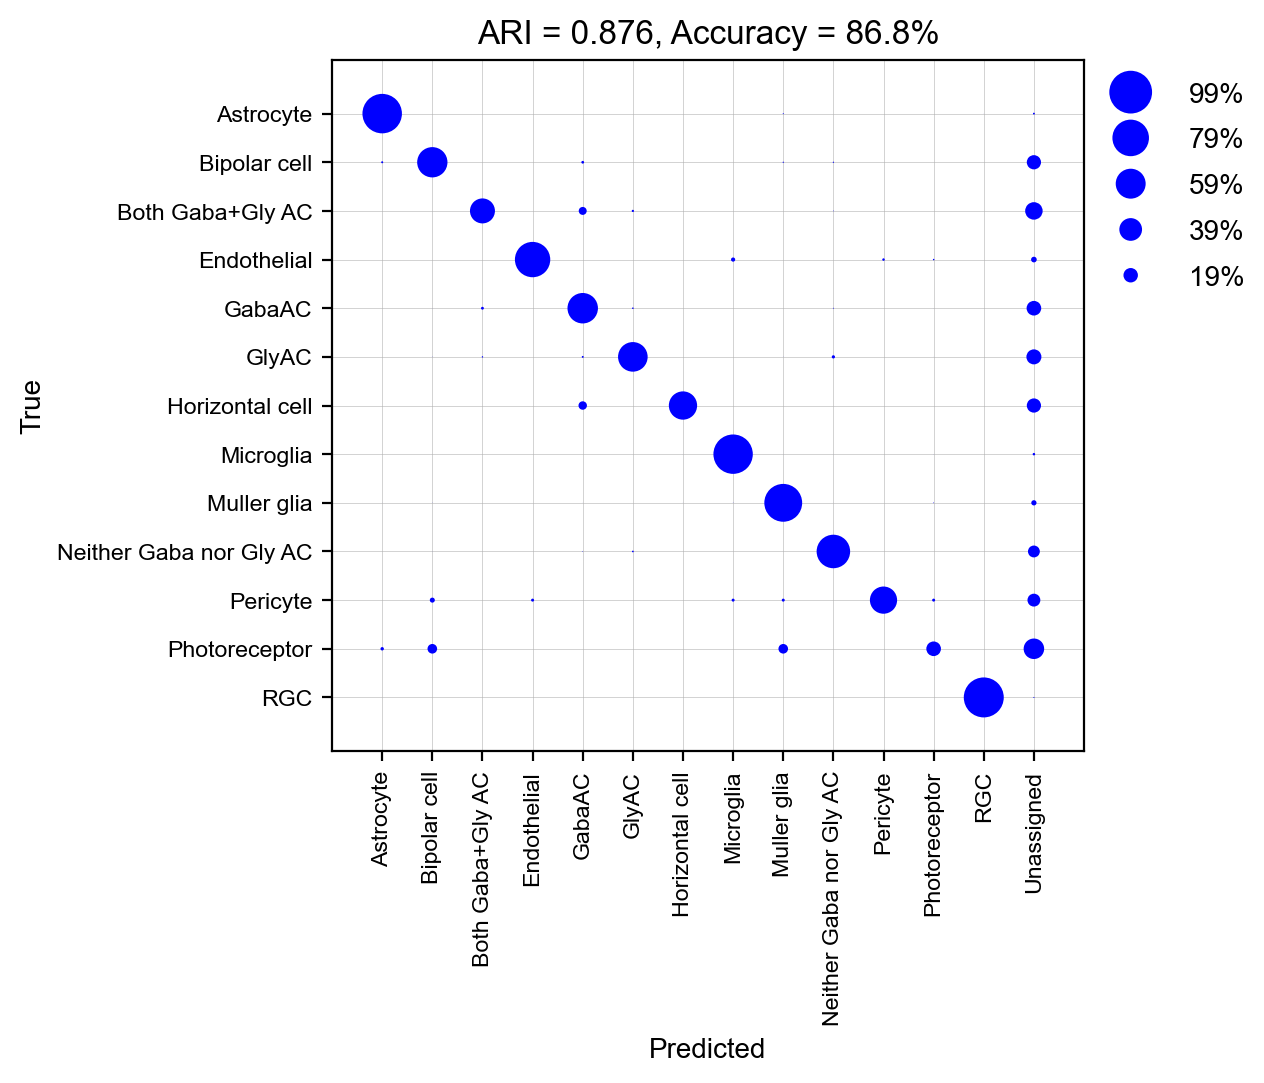

../../spatial_rgc/models/removed_genes/feature_names_130.pickle ../../spatial_rgc/models/retina_class_level/valid_xgb_retina_merged 174 {'Astrocyte': 0, 'Bipolar cell': 1, 'Both Gaba+Gly AC': 2, 'Endothelial': 3, 'GabaAC': 4, 'GlyAC': 5, 'Horizontal cell': 6, 'Microglia': 7, 'Muller glia': 8, 'Neither Gaba nor Gly AC': 9, 'Pericyte': 10, 'Photoreceptor': 11, 'RGC': 12, 'Unassigned': 13}


In [22]:
importlib.reload(constants)
importlib.reload(pu)
importlib.reload(cl)


run_name="tran_yan_ONC_class"


model_info = constants.MODEL_INFO[run_name]
feature_names_f = model_info['feature_names_f']
model_dir = model_info['model_dir']
model_name= model_info['model_name']
rgc_median_transcripts = model_info['median_transcripts']
data_f = model_info['data_f']
train_dict_name = model_info['train_dict_name']
output_dir = os.path.join(BASE_DIR,"figures","retina_classifier")
feature_names_upper_f = model_info['feature_names_upper_f']


#Josh data with capitals
adata_m=sc.read_h5ad(data_f)
if run_name in ['ONC_remapped',"ONC_remapped_123_genes"]:
    adata_m.obs.loc[adata_m.obs['seurat_clusters'].isin([4,31]), 'cell_class'] = 'GabaAC'
    upper_gene_map = {str.upper(k):str.upper(v) for k,v in constants.RENAMED_GENE_MAP.items()}
    adata_m.var.rename(index=upper_gene_map,inplace=True)
elif run_name in ["ONC"]:
    adata_m.var.rename(index=constants.RENAMED_GENE_MAP,inplace=True)
else:
    pass # Other names were processed during creation




# Load merged data
cutoff=0.5
adata_m = pu.rearrange_and_preprocess(adata_m,feature_names_f=feature_names_upper_f,target_sum=rgc_median_transcripts, batch_key=None,save_log=False)
valid_model,model,train_dict,test_dict = cl.run_training_and_validation(adata=adata_m,obs_id='cell_class',model_dir=model_dir, model_name=model_name,output_dir=output_dir, output_f =f"{cutoff}_validation.pdf",train_dict_name=train_dict_name,colsample_bytree=1,nround=200,max_cells_per_ident=1000,min_cells_per_ident=200,max_depth=4)

xgb_model_f=os.path.join(model_dir, f"valid_{model_name}")
model = xgb.Booster()
model.load_model(xgb_model_f)
print(feature_names_f,xgb_model_f,rgc_median_transcripts,train_dict)

Target sum: 174.0
[ 4 14 33  3 30  6 16 11 13  1 19  2  5 18 34  8  0 29 27 23  7 15 21 26
 28  9 35 25 37 22 10 17 12 24 20 32 36 31 38 39] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39} {'Astrocyte': 0, 'Bipolar cell': 1, 'Both Gaba+Gly AC': 2, 'Endothelial': 3, 'GabaAC': 4, 'GlyAC': 5, 'Horizontal cell': 6, 'Microglia': 7, 'Muller glia': 8, 'Neither Gaba nor Gly AC': 9, 'Pericyte': 10, 'Photoreceptor': 11, 'RGC': 12, 'Unassigned': 13}
40 14
    Astrocyte  Bipolar cell  Both Gaba+Gly AC  Endothelial    GabaAC  \
2    0.000370      0.000185          0.208315     0.000074  0.681633   
35   0.001320      0.001760          0.008359     0.000440  0.238451   
4    0.041577      0.003665          0

/Users/kushalnimkar/Documents/PhD/SpatialRGC/spatial_rgc/utils/assorted_utils.py:148: UserWarning: FixedFormatter should only be used together with FixedLocator
  dot_ax.set_xticklabels(xticksactual,rotation=90)


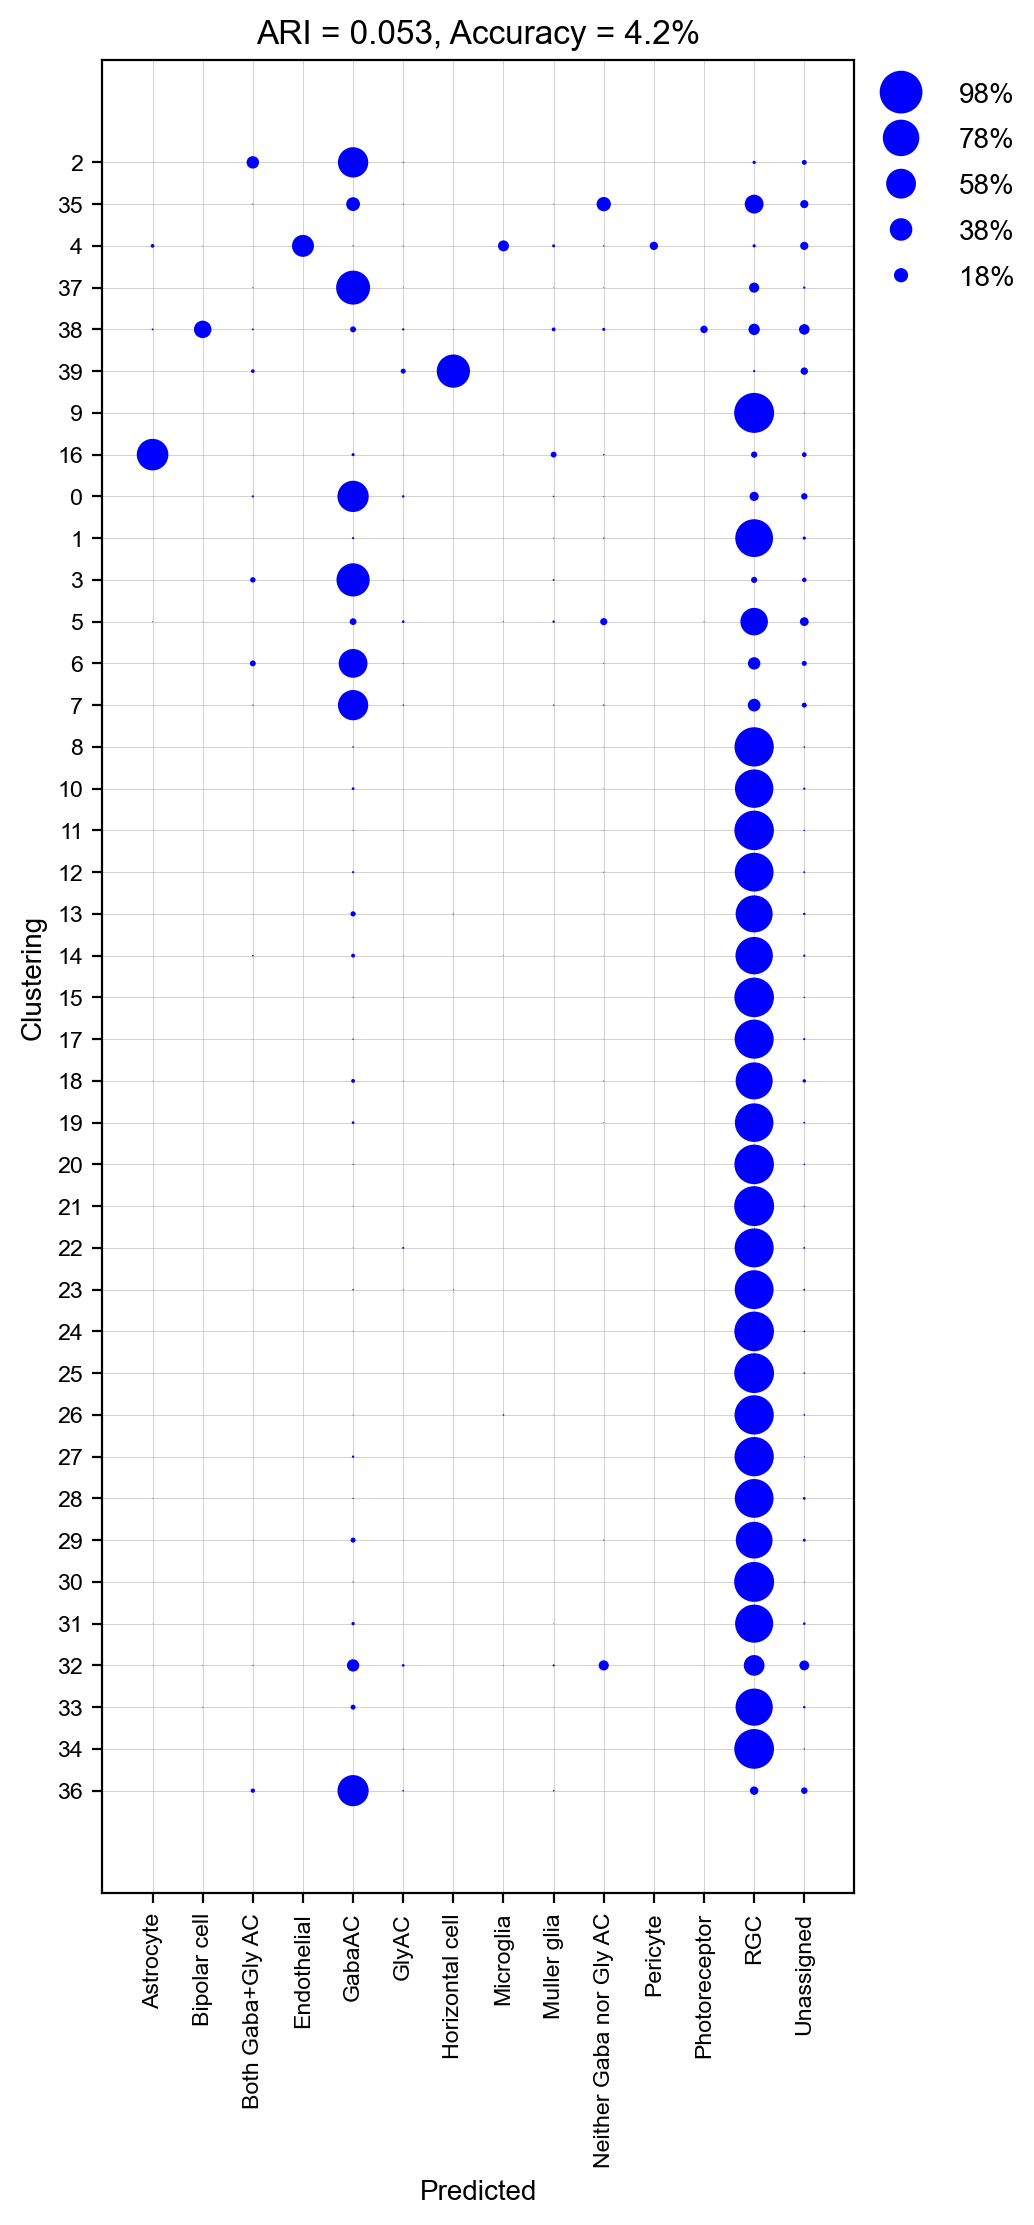

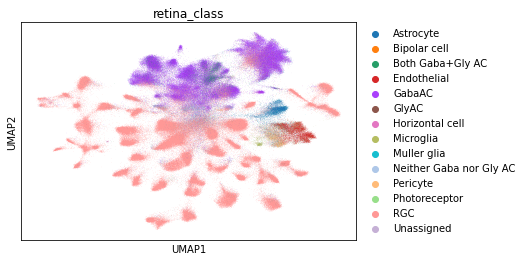

RGC                        211082
GabaAC                      98289
Unassigned                  18343
Both Gaba+Gly AC            10251
Endothelial                  8610
Astrocyte                    6383
Neither Gaba nor Gly AC      4636
Microglia                    4028
Muller glia                  3294
GlyAC                        2996
Pericyte                     2392
Bipolar cell                  492
Photoreceptor                 363
Horizontal cell               354
Name: retina_class, dtype: int64

In [11]:
#Just to sanity check results
adata = sc.read_h5ad(os.path.join(BASE_DIR,"data","control_130_6","merged_control_cluster_patched_v3.h5ad"))
from pandas.api.types import CategoricalDtype
adata = pu.rearrange_and_preprocess(adata,feature_names_f=feature_names_f,target_sum=rgc_median_transcripts, batch_key=None,save_log=False)
cl.apply_model(adata,xgb_model_f,train_dict,cutoff=0.5, output_dir=output_dir,output_f="cluster_vs_prediction_cell_class", unassigned_indicator='Unassigned', prefix=None, test_key='joint_leiden',train_key_added='retina_class',prefix_key=None,xlabel='Predicted',ylabel='Clustering') #Test key is usually clustering
sc.pl.umap(adata,color='retina_class')
adata.obs['retina_class'].value_counts()

In [ ]:
def reassign_others_control(adata, model_dir,model_name,train_dict_f):
    neuronal_classes = {"Bipolar cell","GabaAC",'GlyAC','Neither Gaba nor Gly AC','RGC'}
    non_neuronal_classes = {"Endothelial","Horizontal cell",'Microglia','Muller glia','Pericyte'}
    GROUP_MAP = {'pc/Am+/RGC+': "Other", 'pc/Am+/RGC-':"Amacrine", 'pc/Am-/RGC+':"RGC", 'pc/Am-/RGC-':"Other",'dpc/Am+/RGC+': "N/A", 'dpc/Am+/RGC-':"N/A", 'dpc/Am-/RGC+':"N/A", 'dpc/Am-/RGC-':"N/A"}
    adata.obs['class'] = adata.obs['class'].replace('Endo','Other')

    cutoff=0.5
    cl.apply_model(
        adata=adata,
        model_f=os.path.join(model_dir,model_name),
        train_dict=os.path.join(model_dir,train_dict_f),
        cutoff=cutoff,
        output_dir="scratch",output_f="test.png", 
        unassigned_indicator='Unassigned', 
        prefix='', 
        test_key='joint_leiden',
        train_key_added='retina_class',
        prefix_key=None,
        xlabel='Predicted',
        ylabel='Clustering'
    ) #Test key is usually clustering
    return # Rest isnt necessary since i added to pipeline
    adata.obs['superclass'] = ['Neuron' if x in neuronal_classes else 'Non-neuron' if x in non_neuronal_classes else 'Unassigned' for x in adata.obs['retina_class']]

    confusion_s=pd.crosstab(adata.obs['joint_leiden'], adata.obs['superclass'])
    confusion_m = pd.crosstab(adata.obs['joint_leiden'],adata.obs['class'])

    adata.obs['class'] = adata.obs['class'].cat.add_categories(['Non-neuronal','Low quality neuronal'])
    for c in np.unique(adata.obs['joint_leiden']):

        s = confusion_s.loc[c]
        s=s/np.sum(s)
        m = confusion_m.loc[c]
        m=m/np.sum(m)
        if m['Other']>0.5:
            if s['Non-neuron']+s['Unassigned']>0.7:
                print(f"Remap {c} to be non-neuronal")
                adata.obs.loc[adata.obs['joint_leiden']==c,'class']='Non-neuronal'

    adata.obs.loc[adata.obs['class']=='Other','class']='Low quality neuronal'
    adata.obs['class']= adata.obs['class'].cat.remove_unused_categories()

def patch(adata,run_regions):
    unique_runs = adata.obs['run'].unique()
    for run in run_regions:
        regions = run_regions[run]['regions']
        stains = run_regions[run]['stains']
        adata_arr=[]
        assert run in unique_runs
        for region in regions:
            print(run,region)
            adata_i=sc.read_h5ad(os.path.join(BASE_DIR,"data",f"140g_rn{run}_rg{region}",f"Cellpose_model_c2knl_full_retina.h5ad"))
            print(adata_i)
            adata_arr.append(adata_i)

        adata_p = ad.concat(adata_arr,index_unique='_rg')
        adata_p.obs.index =[id +f"_rn{run}" for id in adata_p.obs.index]
        print(adata_p.obs.index)
        for stain in stains:
            if stain not in adata.obs.columns:
                adata.obs[stain] = adata_p.obs[stain]
            else:
                adata.obs[stain].update(adata_p.obs[stain])

    return adata_p


import constants
import classifier as cl
info = constants.MODEL_INFO['tran_yan_ONC_class']
model_dir=info['model_dir']
model_name=f"valid_{info['model_name']}"
train_dict_f=info['train_dict_name']
run="control_130_6"


run_regions_patch = {
    4:{'regions':[0,1,2,3],'stains':['Anti-Rat']},
    16:{'regions':[0,1,2,3],'stains':['Anti-Rat','Anti-Goat']},
    17:{'regions':[0,1,2,3,4],'stains':['Anti-Rat','Anti-Goat']},
    #14:{'regions':[0,1,2,3,4],'stains':['Anti-Rat','Anti-Goat']}
}


run="control_130_6"
adata=sc.read_h5ad(os.path.join("data",run,"merged_control_cluster.h5ad"))
reassign_others_control(adata, model_dir=model_dir,model_name=model_name,train_dict_f=train_dict_f)
adata_p=patch(adata,run_regions=run_regions_patch)
#adata.write_h5ad(os.path.join("data",run,"merged_control_cluster_patched.h5ad"))


# make_umap(adata,RUN_MAP)


## Train RGC Model

Target sum: [[173.99998 173.99998 173.99998 ... 174.00002 174.00002 174.00008]]
{'C1': 0, 'C2': 1, 'C3': 2, 'C4': 3, 'C5': 4, 'C6': 5, 'C7': 6, 'C8': 7, 'C9': 8, 'C10': 9, 'C11': 10, 'C12': 11, 'C13': 12, 'C14': 13, 'C15': 14, 'C16': 15, 'C17': 16, 'C18': 17, 'C19': 18, 'C20': 19, 'C21': 20, 'C22': 21, 'C23': 22, 'C24': 23, 'C25': 24, 'C26': 25, 'C27': 26, 'C28': 27, 'C29': 28, 'C30': 29, 'C31': 30, 'C32': 31, 'C33': 32, 'C34': 33, 'C35': 34, 'C36': 35, 'C37': 36, 'C38': 37, 'C39': 38, 'C40': 39, 'C41': 40, 'C42': 41, 'C43': 42, 'C44': 43, 'C45': 44, 'Unassigned': 45}
Running train/validation split
Training on 100%
trainclassifier() complete after 451.0 seconds
           C1        C2        C3        C4        C5        C6        C7  \
C1   0.968500  0.022500  0.000500  0.003000  0.000000  0.000000  0.000000   
C2   0.026896  0.953201  0.007531  0.001076  0.000000  0.000000  0.000000   
C3   0.005051  0.016162  0.964646  0.002020  0.000000  0.001010  0.000000   
C4   0.001152  0.00115

/Users/kushalnimkar/Documents/PhD/SpatialRGC/spatial_rgc/utils/assorted_utils.py:148: UserWarning: FixedFormatter should only be used together with FixedLocator
  dot_ax.set_xticklabels(xticksactual,rotation=90)


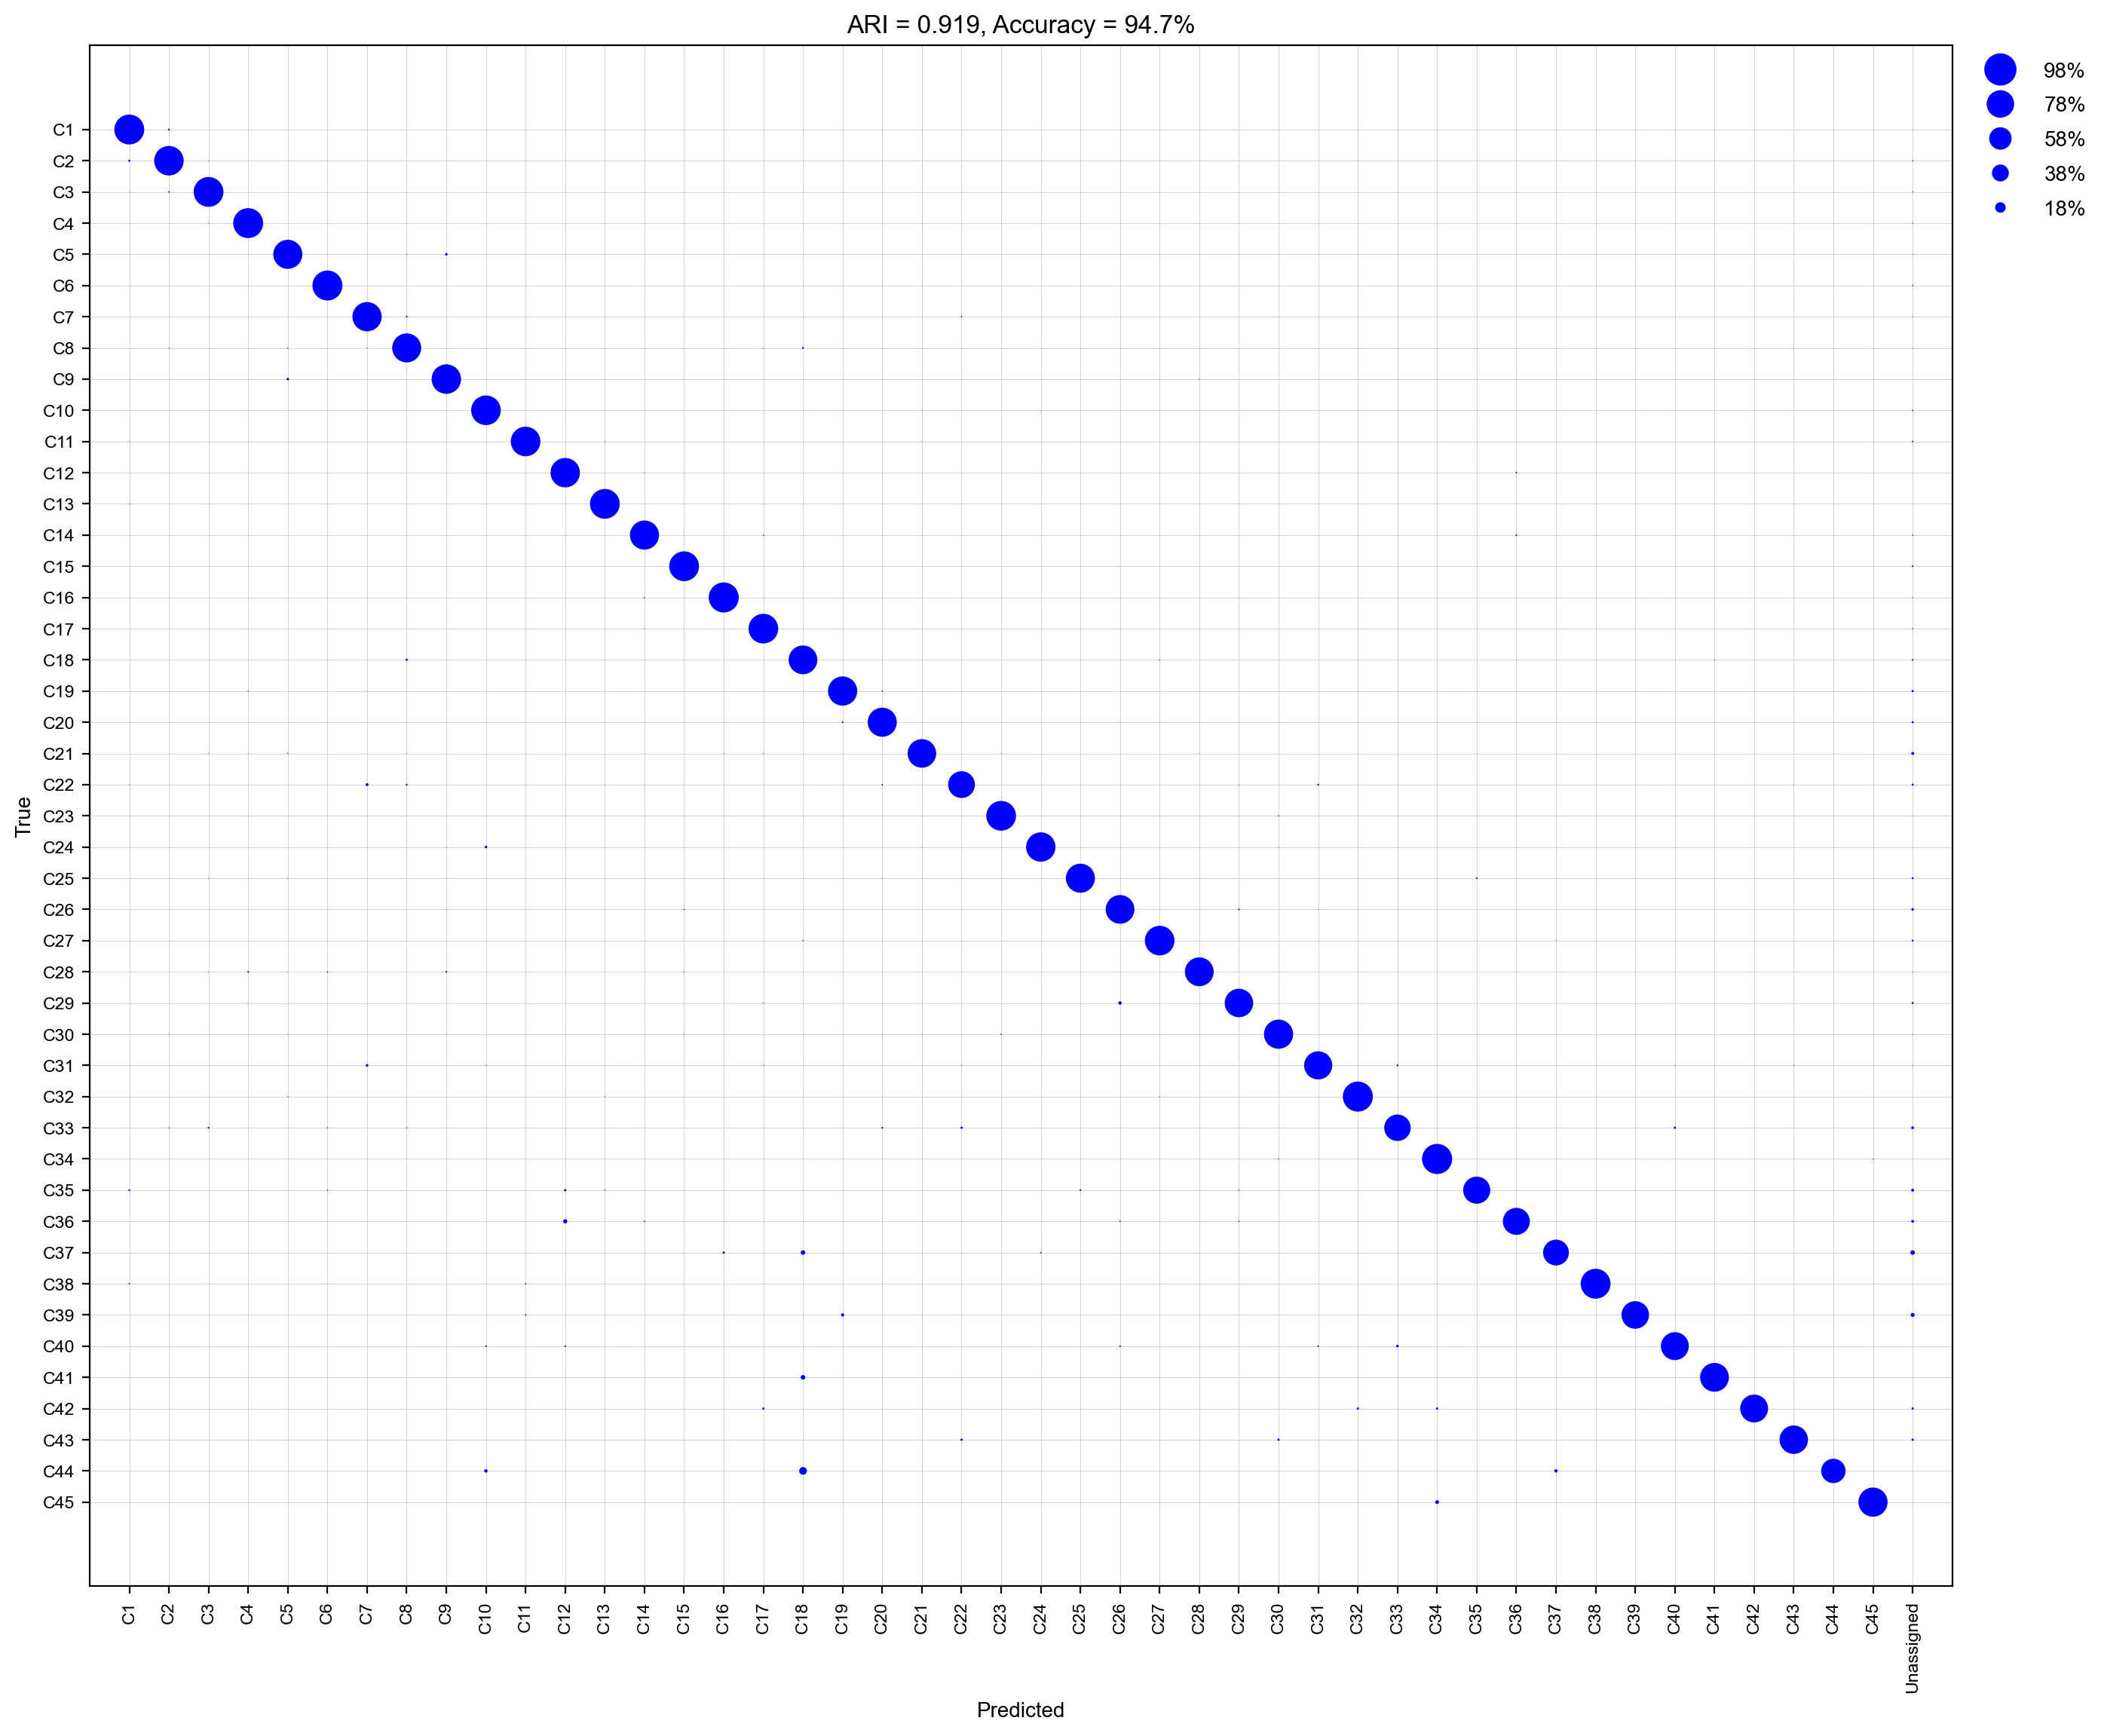

In [24]:
import pickle
import xgboost as xgb

import spatial_rgc.utils.classifier as cl
import spatial_rgc.utils.preprocess_utils as ppu




info ={
    'gene_list':os.path.join(BASE_DIR,"models","removed_genes","feature_names_130.pickle"),
    'renamed_genes_map':constants.RENAMED_GENE_MAP,
    'model_dir':os.path.join(BASE_DIR,"models",'removed_genes'),
    'model_name':'xgb_rgc130',
    'train_dict_name':'train_dict.pickle',
}
output_dir=os.path.join(BASE_DIR,"figures","Figure_1")

adata_ref = sc.read_h5ad(os.path.join(BASE_DIR,"data","atlases","RGCatlas.h5ad"))
adata_ref.obs['Type_num'] = pd.Categorical(adata_ref.obs['Type_num'], categories=[f"C{i+1}" for  i in range(45)] + ['Unassigned'],ordered=True)

#from pandas.api.types import CategoricalDtype
adata_ref.var.rename(index=info['renamed_genes_map'],inplace=True)
adata_ref = ppu.rearrange_and_preprocess(adata_ref,feature_names_f=info['gene_list'],target_sum=None, batch_key=None,save_log=False)#use none for classifier

valid_model,model,train_dict,test_dict = cl.run_training_and_validation(adata=adata_ref,obs_id='Type_num',model_dir=info['model_dir'], cutoff=0.5,model_name=info['model_name'],output_dir=output_dir, output_f =f"{cutoff}_130_validation.pdf",train_dict_name=info['train_dict_name'],colsample_bytree=1,nround=200,max_cells_per_ident=1000,min_cells_per_ident=200,max_depth=4,run_full=True)
